# Text Classification use case

> **Build a classification model that looks at the review text and predicts whether a review is positive or negative.** 😀 / 😖

## Loading libraries 

In [1]:
import spacy
import pandas as pd
pd.set_option("max_colwidth", None)
pd.set_option('precision', 2)
import numpy as np
np.set_printoptions(precision=2)
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy

## Dataset - Amazon Alexa product reviews

In [2]:
df_amazon = pd.read_csv("dataset/amazon_alexa.tsv", sep="\t")
print("There are {0} reviews".format(df_amazon.shape[0]))
print()
df_amazon.head(5)

There are 3150 reviews



,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you. I like being able to turn lights on and off while away from home.",1
3,5,31-Jul-18,Charcoal Fabric,"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
# View data information
df_amazon.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 1.1 MB


In [4]:
df_amazon.feedback.value_counts() / len(df_amazon) * 100

1    91.84
0     8.16
Name: feedback, dtype: float64

## Custom Tokenizer based on spaCy

Create a function that automatically strip information we don’t need, like stopwords and punctuation, from each review.

In [5]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lemma_.lower().strip() for word in mytokens]

    # Removing stop words
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]

    # return preprocessed list of tokens
    return mytokens

spacy_tokenizer("This is a good review !")

['good', 'review']

#### Other ways to create the tokenizer

In [6]:
### Construction 1
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
## Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

## Construction 2
from spacy.lang.en import English
nlp = English()
## Create a Tokenizer with the default settings for English
### including punctuation rules and exceptions
tokenizer = nlp.Defaults.create_tokenizer(nlp)

## Vectorization Feature Engineering

Convert our text inputs into numerical vectors

Several strategies are possible, we will use the one called **Bag of Word**

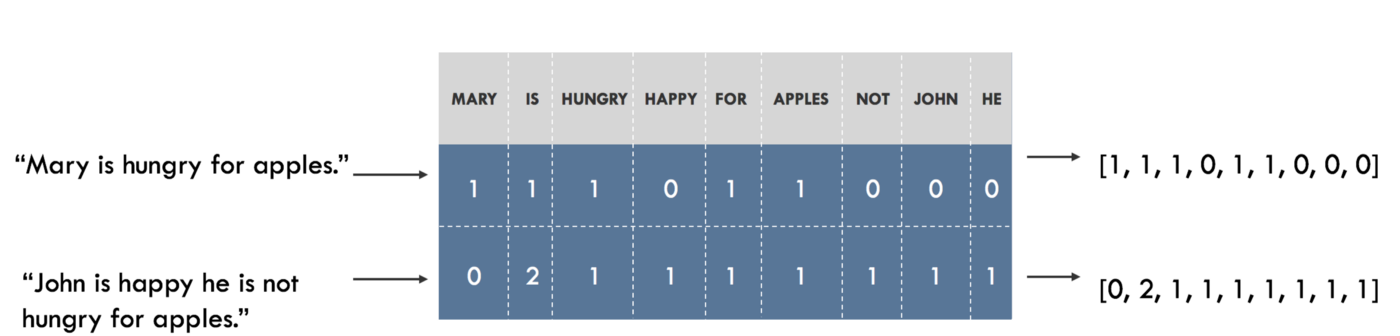

In [7]:
from IPython.display import Image
Image(filename='images/bow_illustration.png')

In [8]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

## Splitting The Data into Training and Test Sets

In [9]:
from sklearn.model_selection import train_test_split

X = df_amazon['verified_reviews'] # the features we want to analyze
ylabels = df_amazon['feedback'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=12345)

## Creating the Pipeline with a Logistic Regression Classifier

In [10]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7f88590e6ca0>)),
                ('classifier', LogisticRegression())])

## Prediction on a new review

In [11]:
my_review = ["I found this article useful"]

print("feedback predicted: {0}".format(pipe.predict(my_review)))
print("feedback probabilities estimated: {0}".format(pipe.predict_proba(my_review)))

feedback predicted: [1]
feedback probabilities estimated: [[0.07 0.93]]


## Evaluating the Model

In [12]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
np.set_printoptions(precision=2)
print("Logistic Regression Accuracy: {0:.2f}".format(metrics.accuracy_score(y_test, predicted)))
print("Logistic Regression Precision: {0:.2f}".format(metrics.precision_score(y_test, predicted)))
print("Logistic Regression Recall:: {0:.2f}".format(metrics.recall_score(y_test, predicted)))

Logistic Regression Accuracy: 0.92
Logistic Regression Precision: 0.93
Logistic Regression Recall:: 0.99
